# VGG16 Classifier Model Training with fruit26 Dataset
---


## Setup Model and Environment

In [1]:
# -----------------------------
#      Import
# -----------------------------
import os
import sys
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%matplotlib inline
#import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
keras = tf.keras
from tensorflow.keras.models import load_model

sys.path.insert(1, os.path.join(os.getcwd(),'pycode')) # for import    
import classifierModelBuilder as cmb
import classifierTrain as cmt

print('TensorFlow version',  tf.__version__)
if (tf.__version__[0]== '1'): 
    print('ERROR: Use TF 2.x')
print('classifierModelTrain',cmt.__version__)

TensorFlow version 2.3.1
classifierModelTrain 3.0.0


In [3]:
# -----------------------------
#      Load Configuration
# -----------------------------
sys.path.insert(1, os.path.join(os.getcwd(),'projectConfig')) # for import 
import config_Vgg16 as cfg

if (os.getcwd()=='/workspace'): 
    print ('Docker environment detected')   
    workDir = '/work'           
    datasetDir = '/dataset' 
else:
    print ('No docker environment detected')
    workDir = 'D:/ml2_work/class_fruit26_vgg16'      
    datasetDir = 'D:/ml2_datasets/fruit26/images'

cmt.workDir = workDir 
logDir = os.path.join(workDir, 'log')
finalDir = os.path.join(workDir, 'modelFinal')
ckptDir = os.path.join(workDir, 'modelCkpts')
    
csvLogFileName = os.path.join(logDir, 'csvLog.csv')
    
print ('workDir:', cmt.workDir)
print ('datasetDir:', datasetDir)

numberOfClassesInDataset = cmt.countNumberOfSubDirs(datasetDir)
print('Number of classes in dataset: ', numberOfClassesInDataset)
if not(numberOfClassesInDataset == cfg.NUMBER_OF_CLASSES):
        print('ERROR: Number of classes in dataset do not fit to model')


preWeightsCacheDir=os.path.join(workDir, 'classifierPretrainedWeights')
cmt.createDir(preWeightsCacheDir)
print('Pretrained weigths cache directory: ', preWeightsCacheDir)


Docker environment detected
workDir: /work
datasetDir: /dataset
Number of classes in dataset:  26
Pretrained weigths cache directory:  /work/classifierPretrainedWeights


In [4]:
# --------------------------------
#      Build Classifier Model
# --------------------------------

model=cmb.buildModel(cfg, preWeightsCacheDir)

# see https://keras.io/guides/transfer_learning/
if cfg.NUMBER_OF_CLASSES==2:
    loss      = "binary_crossentropy"
    metrics   =["accuracy"]
else:
    loss      = tf.keras.losses.CategoricalCrossentropy()    
    metrics   = [tf.keras.metrics.CategoricalAccuracy()]
    
# --------------------------------    
# ---    Build Data Sources    ---    
# --------------------------------

train_ds, val_ds, classNames = cmt.buildGenerators(cfg,  datasetDir)

print('Dataset Directory: ',datasetDir)
print('Number of classes: ',str(cfg.NUMBER_OF_CLASSES))
print('inputScalingType: ',cmb.getInputScalingType(cfg))
print('Class names: ',classNames)

58892288/58889256 [==============================] - 16s 0us/step
Found 3021 files belonging to 26 classes.
Using 2417 files for training.
Found 3021 files belonging to 26 classes.
Using 604 files for validation.
Dataset Directory:  /dataset
Number of classes:  26
inputScalingType:  caffe
Class names:  ['apple gala', 'apple golden', 'apple granny', 'apple pink lady', 'carrot', 'celery', 'coconut', 'cucumber', 'garlic', 'ginger', 'hokkaido', 'lemon', 'none', 'onion', 'onion red', 'orange', 'paprika green', 'paprika red', 'paprika yellow', 'pastinake', 'potato', 'sweet potato', 'tomato', 'tomato mini', 'walnut', 'zucchini']


## Dense Layer Training
Training only the two two dense layers on top of the pretrained base model. 

In [5]:
# --------------------------------
#        Init Training
# --------------------------------

cmt.initTraining(cfg, 
            restartTraining=False,  
            interruptible=True )

cmt.writeModelCfgFilePy(model, classNames,cfg, os.path.join(finalDir,'modelCfg.py'))

cmt.makeTopLayersTrainable(model, 3)
cmt.setDense1DropoutRate(model, 0.5)

model.compile(
    optimizer = keras.optimizers.RMSprop(lr=1e-4),
    loss      = loss,
    metrics   = metrics    
)

cmt.printLayerSummary(model)

initTraining...
Model Layers:
  Layer #0 Name: input_2 Trainable: False
  Layer #1 Name: block1_conv1 Trainable: False
  Layer #2 Name: block1_conv2 Trainable: False
  Layer #3 Name: block1_pool Trainable: False
  Layer #4 Name: block2_conv1 Trainable: False
  Layer #5 Name: block2_conv2 Trainable: False
  Layer #6 Name: block2_pool Trainable: False
  Layer #7 Name: block3_conv1 Trainable: False
  Layer #8 Name: block3_conv2 Trainable: False
  Layer #9 Name: block3_conv3 Trainable: False
  Layer #10 Name: block3_pool Trainable: False
  Layer #11 Name: block4_conv1 Trainable: False
  Layer #12 Name: block4_conv2 Trainable: False
  Layer #13 Name: block4_conv3 Trainable: False
  Layer #14 Name: block4_pool Trainable: False
  Layer #15 Name: block5_conv1 Trainable: False
  Layer #16 Name: block5_conv2 Trainable: False
  Layer #17 Name: block5_conv3 Trainable: False
  Layer #18 Name: block5_pool Trainable: False
  Layer #19 Name: GlobalAveragePooling Trainable: False
  Layer #20 Name: Dens

In [5]:
# 11sec each on hurican
keras.backend.set_value(model.optimizer.lr,0.001)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=16,  verbose=0)



Starting train epochs 0...15 (interruptible with ctrl+c)
Epoch #0: 32.45700645446777s  loss: [1.8197517395019531]
Epoch #1: 10.676944971084595s  loss: [0.5482937097549438]
Epoch #2: 10.81252670288086s  loss: [0.4094339609146118]
Epoch #3: 10.734153509140015s  loss: [0.3267378807067871]
Epoch #4: 10.785442352294922s  loss: [0.2831737697124481]
Epoch #5: 10.776849746704102s  loss: [0.2778962254524231]
Epoch #6: 11.102458953857422s  loss: [0.2129419445991516]
Epoch #7: 10.508530139923096s  loss: [0.22729986906051636]
Epoch #8: 10.521470069885254s  loss: [0.21339304745197296]
Epoch #9: 10.53438925743103s  loss: [0.22922559082508087]
Epoch #10: 10.839110851287842s  loss: [0.1524846851825714]
Epoch #11: 10.814780235290527s  loss: [0.1537238359451294]
Epoch #12: 10.819004535675049s  loss: [0.1483653485774994]
Epoch #13: 10.536396503448486s  loss: [0.16448929905891418]
Epoch #14: 10.576202869415283s  loss: [0.16250041127204895]
Epoch #15: 10.86353874206543s  loss: [0.12768733501434326]


In [6]:
keras.backend.set_value(model.optimizer.lr,0.0005)
cmt.setDense1DropoutRate(model, 0.5)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=20,  verbose=0)

Starting train epochs 16...35 (interruptible with ctrl+c)
Epoch #16: 11.012030839920044s  loss: [0.08704376220703125]
Epoch #17: 10.658713817596436s  loss: [0.06795919686555862]
Epoch #18: 10.680278778076172s  loss: [0.050949275493621826]
Epoch #19: 10.551928043365479s  loss: [0.05148467794060707]
Epoch #20: 10.753631353378296s  loss: [0.045859865844249725]
Epoch #21: 10.968754053115845s  loss: [0.039038535207509995]
Epoch #22: 10.810767412185669s  loss: [0.030532818287611008]
Epoch #23: 10.773045539855957s  loss: [0.023289373144507408]
Epoch #24: 10.504798650741577s  loss: [0.03376864269375801]
Epoch #25: 10.586549758911133s  loss: [0.031243478879332542]
Epoch #26: 10.811309576034546s  loss: [0.029074935242533684]
Epoch #27: 10.54416823387146s  loss: [0.0270795077085495]
Epoch #28: 10.597334623336792s  loss: [0.03225499764084816]
Epoch #29: 10.557565689086914s  loss: [0.028203031048178673]
Epoch #30: 10.559748411178589s  loss: [0.03626047447323799]
Epoch #31: 11.079623699188232s  loss

In [7]:
keras.backend.set_value(model.optimizer.lr,0.0003)
cmt.setDense1DropoutRate(model, 0.5)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=40,  verbose=0)

Starting train epochs 36...75 (interruptible with ctrl+c)
Epoch #36: 10.800034523010254s  loss: [0.015382006764411926]
Epoch #37: 10.842775583267212s  loss: [0.008350808173418045]
Epoch #38: 10.886712312698364s  loss: [0.007734303362667561]
Epoch #39: 10.596198081970215s  loss: [0.009792827069759369]
Epoch #40: 10.918107032775879s  loss: [0.005514634307473898]
Epoch #41: 10.8571617603302s  loss: [0.00600704038515687]
Epoch #42: 10.566920757293701s  loss: [0.005718922708183527]
Epoch #43: 10.588079452514648s  loss: [0.014526876620948315]
Epoch #44: 10.599138975143433s  loss: [0.010189610533416271]
Epoch #45: 10.881804466247559s  loss: [0.005004907492548227]
Epoch #46: 11.182391881942749s  loss: [0.004707211162894964]
Epoch #47: 10.597046852111816s  loss: [0.004893642384558916]
Epoch #48: 10.906062364578247s  loss: [0.0028752887155860662]
Epoch #49: 10.888809204101562s  loss: [0.001397960470058024]
Epoch #50: 10.678242206573486s  loss: [0.004197847563773394]
Epoch #51: 10.832311153411865

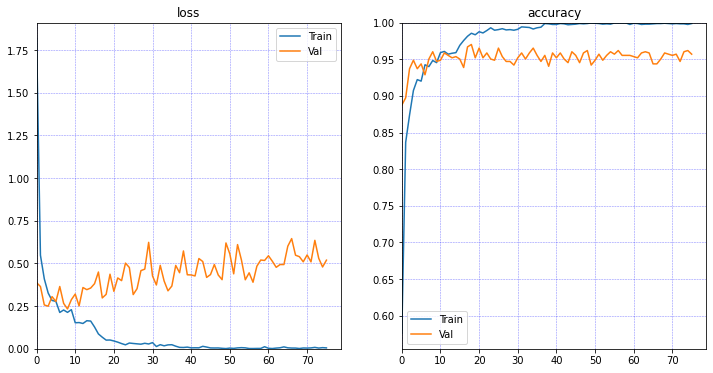

In [8]:
cmt.csvLogPlt(csvLogFileName)

In [17]:
cmt.finalize_training(cfg, model)

Finalize trained model
Reloading model checkpoint file: ckpt_e00070_loss0.00035_lossVal0.42197.h5
Writing trained model file


In [46]:
#model.load_weights(os.path.join(ckptDir, 'ckpt_e00075_loss0.15990_lossVal0.22244.h5'))

## Fine-Tuning 3 Base Model Layers (optional)

In [10]:

cmt.makeTopLayersTrainable(model,8)
model.compile(    
    optimizer = keras.optimizers.RMSprop(lr=1e-4),
    loss      = loss,
    metrics   = metrics    
)
keras.backend.set_value(model.optimizer.lr,0.00002)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=8,  verbose=0)

Starting train epochs 84...91 (interruptible with ctrl+c)
Epoch #84: 12.910467624664307s  loss: [0.049997735768556595]
Epoch #85: 11.931529998779297s  loss: [0.06800922751426697]
Epoch #86: 12.041724681854248s  loss: [0.05348123610019684]
Epoch #87: 11.892468452453613s  loss: [0.04391048103570938]
Epoch #88: 12.121380805969238s  loss: [0.03440944477915764]
Epoch #89: 11.932464599609375s  loss: [0.023170867934823036]
Epoch #90: 12.001660823822021s  loss: [0.007873139344155788]
Epoch #91: 12.22436237335205s  loss: [0.026454754173755646]


In [12]:
keras.backend.set_value(model.optimizer.lr,0.00002)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=22,  verbose=0)

Starting train epochs 92...113 (interruptible with ctrl+c)
Epoch #92: 12.14852523803711s  loss: [0.019556554034352303]
Epoch #93: 12.45944333076477s  loss: [0.011403807438910007]
Epoch #94: 13.199686765670776s  loss: [0.02686690166592598]
Epoch #95: 13.250272035598755s  loss: [0.008816765621304512]
Epoch #96: 12.519819736480713s  loss: [0.008751120418310165]
Epoch #97: 12.274696588516235s  loss: [0.005321964155882597]
Epoch #98: 12.588878154754639s  loss: [0.005430129356682301]
Epoch #99: 12.245198488235474s  loss: [0.0028183909598737955]
Epoch #100: 12.411293029785156s  loss: [0.011882482096552849]
Epoch #101: 12.379003286361694s  loss: [0.010093474760651588]
Epoch #102: 12.365298986434937s  loss: [0.012377098202705383]
Epoch #103: 12.557578802108765s  loss: [2.2035612346371636e-05]
Epoch #104: 12.244903802871704s  loss: [0.0011946279555559158]
Epoch #105: 12.716960191726685s  loss: [1.7613015188544523e-06]
Epoch #106: 12.561474561691284s  loss: [0.004214792978018522]
Epoch #107: 12.3

In [14]:
keras.backend.set_value(model.optimizer.lr,0.00002)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=10,  verbose=0)

Starting train epochs 114...123 (interruptible with ctrl+c)
Epoch #114: 12.440074443817139s  loss: [0.012444029562175274]
Epoch #115: 11.739068746566772s  loss: [0.0014864228432998061]
Epoch #116: 12.365431547164917s  loss: [1.2159363222963293e-06]
Epoch #117: 11.812232255935669s  loss: [0.0020675102714449167]
Epoch #118: 12.02168083190918s  loss: [0.001816768548451364]
Epoch #119: 11.879176616668701s  loss: [0.0003429335483815521]
Epoch #120: 11.888840913772583s  loss: [0.004557509906589985]
Epoch #121: 12.32269024848938s  loss: [0.005781061016023159]
Epoch #122: 12.761729717254639s  loss: [0.009346455335617065]
Epoch #123: 13.00649642944336s  loss: [0.014166552573442459]


In [16]:
keras.backend.set_value(model.optimizer.lr,0.00001)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=10,  verbose=0)


Starting train epochs 124...133 (interruptible with ctrl+c)
Epoch #124: 12.054768323898315s  loss: [0.0005795106408186257]
Epoch #125: 11.914448976516724s  loss: [0.00036376851494424045]
Epoch #126: 12.048807144165039s  loss: [0.0002930659684352577]
Epoch #127: 11.985920190811157s  loss: [1.9542727386578918e-05]
Epoch #128: 11.86899709701538s  loss: [0.00045579776633530855]
Epoch #129: 12.106830835342407s  loss: [2.796334968024894e-07]
Epoch #130: 11.91364860534668s  loss: [2.8867916626040824e-06]
Epoch #131: 12.279533386230469s  loss: [7.985340744198766e-06]
Epoch #132: 11.909435749053955s  loss: [3.6052708196621097e-07]
Epoch #133: 11.934698343276978s  loss: [0.0008100406848825514]


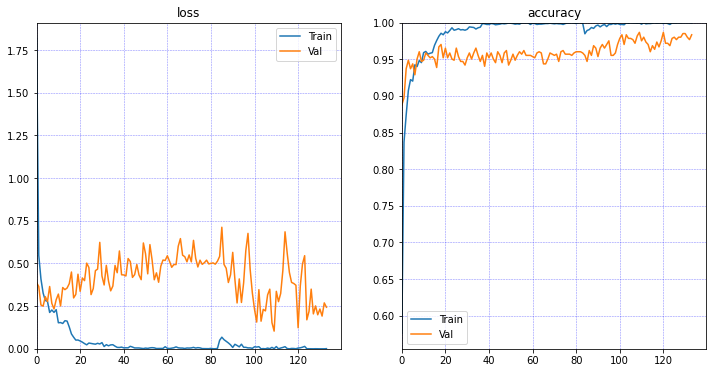

In [17]:
cmt.csvLogPlt(csvLogFileName)

In [9]:
cmt.finalize_training(cfg, model)

## Fine-Tuning all Base Model Layers (optional)

In [18]:

cmt.makeTopLayersTrainable(model, -1)

model.compile(
    #optimizer=keras.optimizers.Adam(1e-3),
    optimizer = keras.optimizers.Adam(0.000002),
    #optimizer =optimizer,
    loss      = loss,
    metrics   = metrics    
)

cmt.printLayerSummary(model)

Model Layers:
  Layer #0 Name: input_2 Trainable: True
  Layer #1 Name: block1_conv1 Trainable: True
  Layer #2 Name: block1_conv2 Trainable: True
  Layer #3 Name: block1_pool Trainable: True
  Layer #4 Name: block2_conv1 Trainable: True
  Layer #5 Name: block2_conv2 Trainable: True
  Layer #6 Name: block2_pool Trainable: True
  Layer #7 Name: block3_conv1 Trainable: True
  Layer #8 Name: block3_conv2 Trainable: True
  Layer #9 Name: block3_conv3 Trainable: True
  Layer #10 Name: block3_pool Trainable: True
  Layer #11 Name: block4_conv1 Trainable: True
  Layer #12 Name: block4_conv2 Trainable: True
  Layer #13 Name: block4_conv3 Trainable: True
  Layer #14 Name: block4_pool Trainable: True
  Layer #15 Name: block5_conv1 Trainable: True
  Layer #16 Name: block5_conv2 Trainable: True
  Layer #17 Name: block5_conv3 Trainable: True
  Layer #18 Name: block5_pool Trainable: True
  Layer #19 Name: GlobalAveragePooling Trainable: True
  Layer #20 Name: Dense1 Trainable: True
  Layer #21 Name:

In [19]:
keras.backend.set_value(model.optimizer.lr,0.000005)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=8,  verbose=0)

Starting train epochs 134...141 (interruptible with ctrl+c)
Epoch #134: 31.876001834869385s  loss: [2.3723281117327133e-08]
Epoch #135: 27.35442328453064s  loss: [0.0012160544283688068]
Epoch #136: 27.85143804550171s  loss: [0.12673594057559967]
Epoch #137: 27.693098783493042s  loss: [0.005421748384833336]
Epoch #138: 27.538829565048218s  loss: [0.00018548320804256946]
Epoch #139: 27.582420110702515s  loss: [0.0003788794274441898]
Epoch #140: 27.609118461608887s  loss: [0.004969124682247639]
Epoch #141: 76.6731219291687s  loss: [0.00326192332431674]


In [21]:
keras.backend.set_value(model.optimizer.lr,0.000005)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=8,  verbose=0)

Starting train epochs 142...149 (interruptible with ctrl+c)
Epoch #142: 27.995422840118408s  loss: [0.0039634620770812035]
Epoch #143: 28.062783002853394s  loss: [5.8762787375599146e-05]
Epoch #144: 27.435121536254883s  loss: [0.06582263112068176]
Epoch #145: 27.550552368164062s  loss: [0.020407985895872116]
Epoch #146: 28.119988441467285s  loss: [0.022633668035268784]
Epoch #147: 27.94351577758789s  loss: [0.004007632844150066]
Epoch #148: 28.388678073883057s  loss: [0.006892296019941568]
Epoch #149: 28.92428755760193s  loss: [0.003411650424823165]


In [23]:
keras.backend.set_value(model.optimizer.lr,0.000005)
hist = cmt.trainModel(cfg, model, train_ds, val_ds, epochs=20,  verbose=0)

Starting train epochs 150...169 (interruptible with ctrl+c)
Epoch #150: 27.98451256752014s  loss: [0.0028165928088128567]
Epoch #151: 28.144854068756104s  loss: [0.02120402455329895]
Epoch #152: 28.835105657577515s  loss: [0.024658620357513428]
Epoch #153: 27.955727338790894s  loss: [0.004973707254976034]
Epoch #154: 27.648653030395508s  loss: [0.0002199360606027767]
Epoch #155: 27.664841175079346s  loss: [0.0004692726070061326]
Epoch #156: 27.89045548439026s  loss: [0.00015455835091415793]
Epoch #157: 27.669875860214233s  loss: [7.853742863517255e-05]
Epoch #158: 27.6840078830719s  loss: [0.0023895364720374346]
Epoch #159: 27.675979137420654s  loss: [0.00045253438293002546]
Epoch #160: 27.76893973350525s  loss: [0.0001794821728253737]
Epoch #161: 30.23060703277588s  loss: [6.893081445014104e-05]
Epoch #162: 28.842520475387573s  loss: [0.0001671937498031184]
Epoch #163: 27.985098838806152s  loss: [5.118692206451669e-05]
Epoch #164: 28.116026639938354s  loss: [4.7101166273932904e-05]
Ep

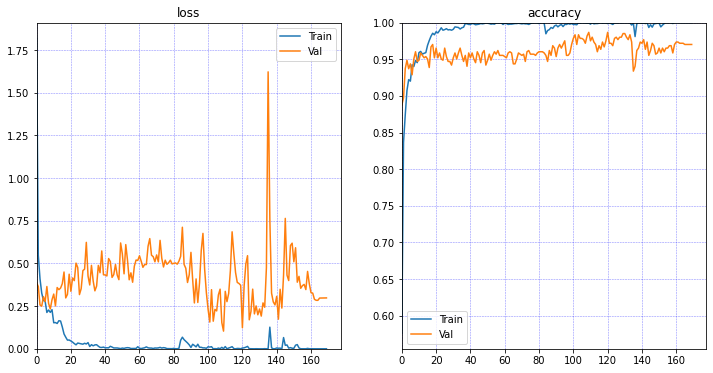

In [25]:
cmt.csvLogPlt(csvLogFileName)

In [13]:
cmt.finalize_training(cfg, model)

## Measure Model Performance

In [26]:
resTrain=model.evaluate(train_ds)
resVal=model.evaluate(val_ds)
#val_aug_ds = val_in_ds.map(lambda x, y: (augmentationSeq(x, training=True),y))
#val_aug_scales_ds = val_aug_ds.map(lambda x,y: (pixel_scaling(x),y))
#resValAug=model.evaluate(val_aug_scales_ds)
print('--- Train Data Set ---')
print(model.metrics_names[0]+':  '+str(resTrain[0]))
print(model.metrics_names[1]+':  '+str(resTrain[1]))
print('--- Validation Data Set ---')
print(model.metrics_names[0]+':  '+str(resVal[0]))
print(model.metrics_names[1]+':  '+str(resVal[1]))
#print('--- Validation Data Set with Augmentation ---')
#print(model.metrics_names[0]+':  '+str(resValAug[0]))
#print(model.metrics_names[1]+':  '+str(resValAug[1]))

31/31 [==============================] - 2s 78ms/step - loss: 0.2981 - categorical_accuracy: 0.9702
--- Train Data Set ---
loss:  1.5638366903658607e-06
categorical_accuracy:  1.0
--- Validation Data Set ---
loss:  0.2980583608150482
categorical_accuracy:  0.9701986908912659


## Show Train Dataset Images and Augmentation


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Found 3021 files belonging to 26 classes.


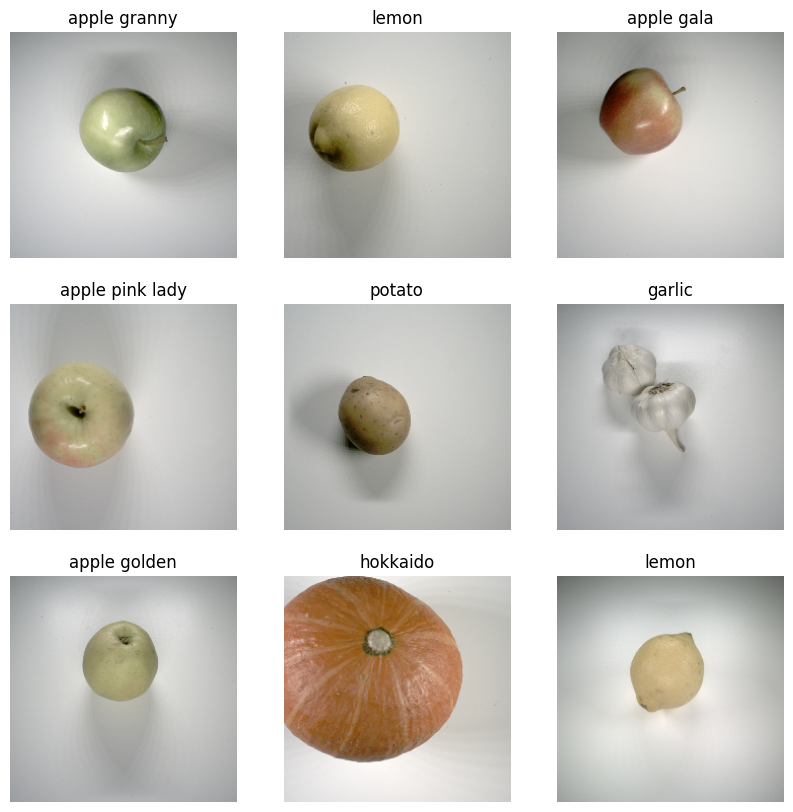

In [13]:
if cfg.NUMBER_OF_CLASSES==2:
    label_mode="int"        
else:
    label_mode="categorical" 

train_in_ds = keras.preprocessing.image_dataset_from_directory(
        datasetDir,
        label_mode = label_mode,
        image_size = (cfg.IMAGE_HEIGHT,cfg.IMAGE_WIDTH),
        batch_size = cfg.BATCH_SIZE
    )

plt.figure(figsize=(10, 10))
for images, labels in train_in_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        labelTxt=train_in_ds.class_names[np.argmax(labels[i], axis=-1)]
        plt.title(labelTxt)
        plt.axis("off")


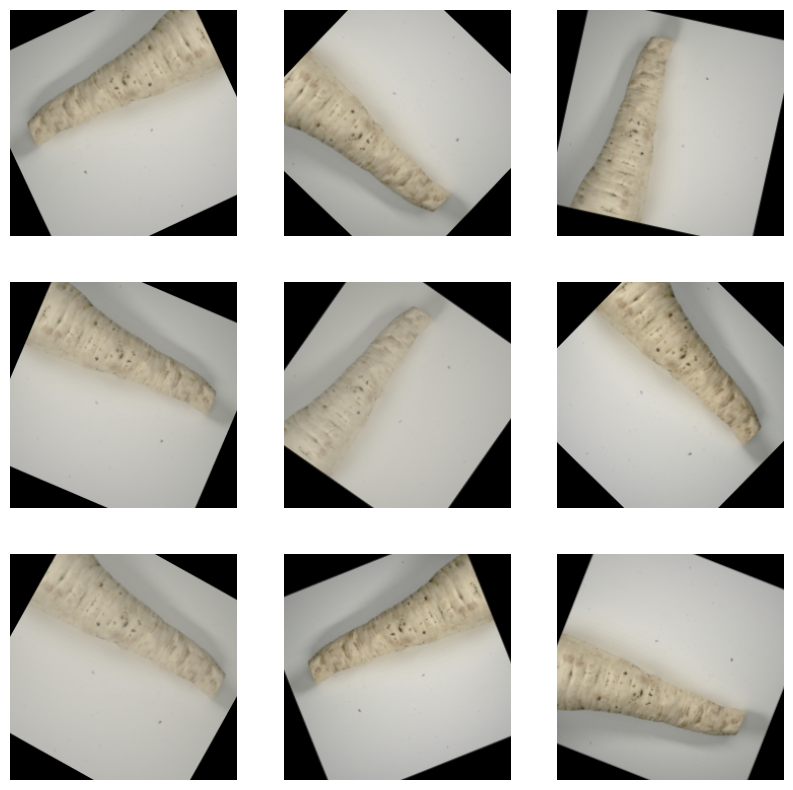

In [14]:
if cfg.USE_AUGMENTATION:
        augmentationSeq = keras.Sequential(name="augmentationSeq")
        if cfg.RANDOM_FLIP_HORIZONTAL:
            augmentationSeq.add(keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
        if cfg.RANDOM_FLIP_VERTICAL:
            augmentationSeq.add(keras.layers.experimental.preprocessing.RandomFlip("vertical"))
        if (abs(cfg.RANDOM_CONTRAST[0])>0) or (abs(cfg.RANDOM_CONTRAST[1])>0):
            augmentationSeq.add(keras.layers.experimental.preprocessing.RandomContrast(cfg.RANDOM_CONTRAST))
        if (abs(cfg.RANDOM_ZOOM[0])>0) or (abs(cfg.RANDOM_ZOOM[1])>0):
            augmentationSeq.add(keras.layers.experimental.preprocessing.RandomZoom( cfg.RANDOM_ZOOM, fill_mode="constant", interpolation="bilinear"))
        if (abs(cfg.RANDOM_ROTATION[0])>0) or (abs(cfg.RANDOM_ROTATION[1])>0):
            augmentationSeq.add(keras.layers.experimental.preprocessing.RandomRotation(cfg.RANDOM_ROTATION, fill_mode="constant", interpolation="bilinear"))

plt.figure(figsize=(10, 10))
for images, _ in train_in_ds.take(1):
    for i in range(9):
        #augmented_images = data_augmentation(images)
        augmented_images = augmentationSeq(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
